## Домашнее задание по имууногеномике. __Constructing clonal lineages__

__ИБ. осень 2020.__
__Чангалиди Антон__



(I used IgBlast)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pylab as plt

The purpose of this assignment is to reconstruct clonal lineages for an antibody repertoire taken after a seasonal flu vaccination and analyze their properties. To complete the assignment, follow the instructions:


### Task 1.
Download the repertoire file in FASTA format. It consists of 10,000 sequences. 

It is in the `PRJNA324093_Dnr4_10k.fasta` file.



### Task 2.
(5 points + 5 points) Implement reconstruction of clonal lineages using the Hamming graph (HG) on CDR3s through the following steps: 
* Compute CDR3s of sequences (e.g., using IgBlast or DiversityAnalyzer, see HW #1 for the details). File:  `igblast_results.tsv`
* Compute Hamming distances (HD) for pairs of the computed CDR3s. 
* Connect two sequences s1 and s2 by an edge if (i) their CDR3s have the same lengths L and  (ii) the HD(CDR3_s1, CDR3_s2) / L ≤ 0.2 (i.e., similarity is at least 80%). Since processing all pairs of sequences takes too much time, optimizations are welcome. Implementation and its brief description of any optimization add 5 points to this part.  
* Report connected components of the HG as clonal lineages.
* Attach the implemented code to your report.


Нам нужны только CDR3, а так же их длина (потому что считать HD мы можем только для строк одинаковой длины):

In [6]:
data = pd.read_csv('igblast_results.tsv', sep = '\t')
data_cdr3 = data.loc[:, ['cdr3']]
data_cdr3['length'] = data_cdr3['cdr3'].apply(len)
data_cdr3 = data_cdr3.sort_values(by='length')
data_cdr3.head()

,cdr3,length
5089,GCGAGAGATTATAAC,15
1029,GCGAGAGATTATAAA,15
2949,GCGAGAGATTATAAC,15
144,GCGAGAGATTATAAA,15
4345,GCGAGAGATTATAAA,15


Интересно посмотреть на распределение длины cdr3:

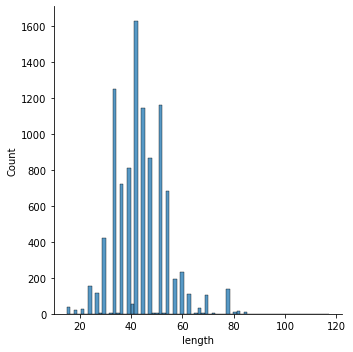

In [4]:
sns.displot(data_cdr3.length)

Так как HD будем считать только для строк одинаковой длины, сгруппируем их и создадим для каждой длины свой лист: так мы будем перебирать не $n^2$ пар, а в разы меньше - __оптимизация №1__

In [11]:
# group by length
# create unique list of names
UniqueNames = data_cdr3['length'].unique()
# create a data frame dictionary to store lists of sequences
cdrs_list = {elem: pd.DataFrame for elem in UniqueNames}
for key in data_dict.keys():
    cdrs_list.update({key: data_cdr3[:][data_cdr3['length'] == key].cdr3.to_list()})

Напишем функцию для подсчета дистанции Хэмминга (__с оптимизацией №2__): 
* если мы при подсчете уже получили HD(CDR3_s1, CDR3_s2) / L ≤ 0.2 - дальше считать не будем, просто вернем False (т.е. строчки связывать ребром не надо).

In [21]:
def check_hamming_dist(s1, s2, cut = 0.2):
    '''
        Функция, считающая дистанцию hamming'a, 
        
        Returns:
            True, только в том случае, если HD/len <= cut
            False - иначе
            
        Здесь выполнена оптимизация: если мы при подсчете 
        уже получили HD/len > cut - дальше считать не будем.  
    '''
    assert len(s1) == len (s2), 'Strings must be the same length to calculate HD.'
    length = len(s1)
    dist = 0
    for let1, let2 in zip(s1, s2):
        dist += (let1 != let2)
        if dist / length > cut:
            return False
    return True

In [22]:
%%time
graph = nx.Graph()
for length, seqs in cdrs_list.items():
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs[i:]):
            if check_hamming_dist(seq1, seq2):
                graph.add_edge(seq1, seq2)

CPU times: user 11.8 s, sys: 3.49 ms, total: 11.8 s
Wall time: 11.9 s


### Task 3.

(5 points) Analyze the computed clonal lineages and fill blank cells in Table 1:




In [23]:
print(f'The number of clonal lineages: {nx.number_connected_components(graph)}')

comp = nx.connected_components(graph)
list_c = []
for i in comp:
    list_c.append(i)
#     print(len(i), i)
# print(list_c)
giant = max(list_c, key=len)
print(f'The number of sequences in the largest lineage: {len(giant)}')

graph_10 = np.array([len(el) for el in list_c])
count_10 = np.sum(graph_10 >= 10)
print(f'The number of clonal lineages presented by at least 10 sequences: {count_10}')

The number of clonal lineages: 546
The number of sequences in the largest lineage: 122
The number of clonal lineages presented by at least 10 sequences: 46


<table class="tg">
<tbody>
  <tr>
    <td class="tg-fymr"><span style="font-weight:400;font-style:normal;text-decoration:none;color:#000;background-color:transparent">The number of clonal lineages</span></th>
    <td class="tg-fymr">546</th>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none;color:#000;background-color:transparent">The number of sequences in the largest lineage</span></td>
    <td class="tg-0pky">122</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none;color:#000;background-color:transparent">The number of clonal lineages presented by at least 10 sequences</span></td>
    <td class="tg-0pky">46</td>
  </tr>
</tbody>
</table>

_Table 1._

### Task 4.
(5 points) For each lineage, compute the closest V gene (e.g., using IgBlast or DiversityAnalyzer, see HW #1 for the details), create a usage plot of the computed V genes (x axis shows V genes, y axis shows the number of clonal lineages formed by each of V genes), and insert it below:

[V usage plot]


### Task 5. 
(5 points) Create a web logo plot of CDR3s from the largest clonal lineage and insert it below:



In [35]:
%config InlineBackend.figure_format = 'svg'
with open('giant_lineage.fa', 'w') as f:
    for item in giant:
        f.write(">seq\n%s\n" % item)

In [39]:
!weblogo < giant_lineage.fa > sequence_logo.png -n 150

![hey](./sequence_logo.png)

### Task 6. 
(5 points) Extract VDJ sequences from the largest lineage and compute their phylogenetic tree (e.g., using Clustal Omega https://www.ebi.ac.uk/tools/msa/clustalo). Visualize the resulting tree (e.g., via Iroki tool: http://www.iroki.net/viewer) and add it below:
 
[Tree figure]  
